In [12]:
import numpy as np
from my_render.my_render import get_ModelView, get_intrinsic, get_view_port, triangle
from my_render.my_shaders import GouraudShader, GouraudShader_texture
from my_render.obj_parser import Model

import matplotlib.pyplot as plt
from skimage.io import imread

In [13]:
def run_render(shader, model):
    width  = 800
    height = 800
    depth = 255
    eye = np.array([1,1,3]) #np.array([0,0,3])#
    center = np.array([0,0,0])
    up = np.array([0,1,0])
    c = np.linalg.norm(eye-center)
    light_dir = (np.array([-2,-2,-1])) #np.array([0,0,-1])#
    light_dir = light_dir/np.linalg.norm(light_dir)

    plane = np.zeros((width,height,3))
    z_buffer = np.ones((width,height)) * (-np.inf)
    minv = get_ModelView(eye, center, up)
    intrinsic = get_intrinsic(c)
    view_port = get_view_port(width * 2/3, height * 2/3, depth)

    shader = shader(model, view_port, intrinsic, minv, light_dir)

    for i in range(len(model.triangles)):
        cur_trian = []
        for j in range(3):
            cur_trian.append(shader.vertex(i, j))

        plane, z_buffer = triangle(np.array(cur_trian), shader, plane, z_buffer)
    return plane, z_buffer

In [14]:
class GouraudShader_normal(GouraudShader):
    var_intens = np.zeros(3)
    var_text_coord = np.zeros((3, 2))

    def vertex(self, iface, nth_vert):
        self.var_text_coord[nth_vert] = self.model.texture_coord[iface, nth_vert] * [
            self.model.texture.shape[1],
            self.model.texture.shape[0],
        ]
        cur_vert = self.add_1_to_vert(self.model.triangles[iface, nth_vert])
        cur_vert = self.view_port.dot(self.intrinsic.dot(self.minv.dot(cur_vert.T)))
        
        self.M = self.intrinsic.dot(self.minv)
        self.MIT = np.linalg.inv(self.M.T)
        return cur_vert

    def fragment(self, bar):
        text_coord = self.var_text_coord.T.dot(bar).astype("int32")
        norm = self.model.normal_map[-text_coord[1], text_coord[0]].astype('float32')
        norm = 2*norm/255 - 1
        norm = self.MIT.dot(self.add_1_to_vert(norm))
        norm = norm[:-1]/norm[-1]
        norm /= -np.linalg.norm(norm)
        
        light_dir = self.M.dot(self.add_1_to_vert(self.light_dir))
        light_dir = light_dir[:-1]/light_dir[-1]
        light_dir /= np.linalg.norm(light_dir)

        intense = np.maximum(0, (norm*light_dir).sum())
        color = self.model.texture[-text_coord[1], text_coord[0]] * intense 
        return color

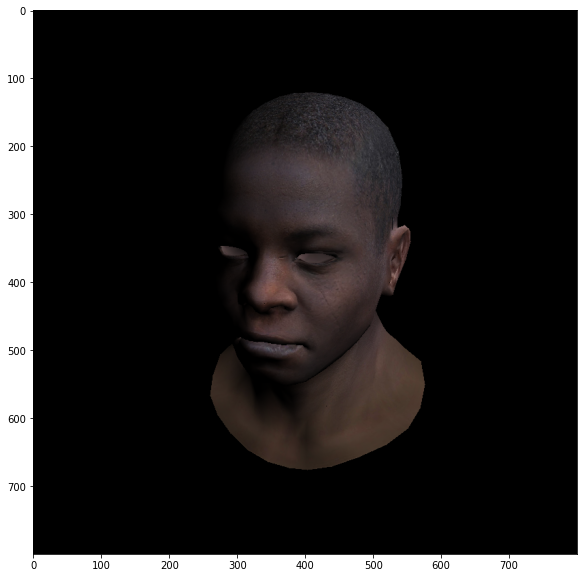

In [17]:
model = Model('./obj/african_head.obj', './obj/african_head_diffuse.png', './obj/african_head_nm.png')
plane, z_buffer = run_render(GouraudShader_texture, model)
plt.figure(figsize=(10,10))
plt.imshow(plane.astype('int32'))

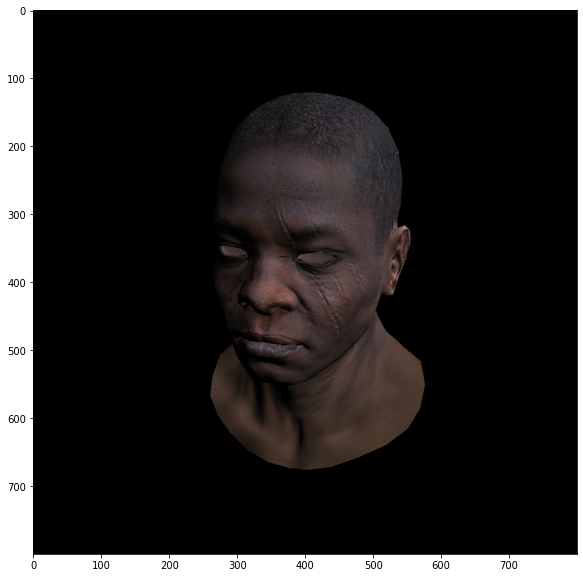

In [526]:
model = Model('./obj/african_head.obj', './obj/african_head_diffuse.png', './obj/african_head_nm.png')
plane, z_buffer = run_render(GouraudShader_normal, model)
plt.figure(figsize=(10,10))
plt.imshow(plane.astype('int32'))

----

In [6]:
class GouraudShader_specular(GouraudShader):
    var_intens = np.zeros(3)
    var_text_coord = np.zeros((3, 2))

    def vertex(self, iface, nth_vert):
        self.var_text_coord[nth_vert] = self.model.texture_coord[iface, nth_vert] * [
            self.model.texture.shape[1],
            self.model.texture.shape[0],
        ]
        cur_vert = self.add_1_to_vert(self.model.triangles[iface, nth_vert])
        cur_vert = self.view_port.dot(self.intrinsic.dot(self.minv.dot(cur_vert.T)))
        
        self.M = self.intrinsic.dot(self.minv)
        self.MIT = np.linalg.inv(self.M.T)
        return cur_vert

    def fragment(self, bar):
        text_coord = self.var_text_coord.T.dot(bar).astype("int32")
        
        norm = self.model.normal_map[-text_coord[1], text_coord[0]].astype('float32')
        norm = 2*norm/255 - 1
        norm = self.MIT.dot(self.add_1_to_vert(norm))
        norm = norm[:-1]/norm[-1]
        norm /= -np.linalg.norm(norm)
        
        light_dir = self.M.dot(self.add_1_to_vert(self.light_dir))
        light_dir = light_dir[:-1]/light_dir[-1]
        light_dir /= np.linalg.norm(light_dir)
        
        r = 2 * norm * norm.dot(light_dir)- light_dir
        r /= np.linalg.norm(r)
        
        spec = self.model.spec_map[-text_coord[1], text_coord[0]].astype('float32')
        spec = np.maximum(-r[2], 0)**spec
        
        diffuse = np.maximum(0, (norm*light_dir).sum())
        color = self.model.texture[-text_coord[1], text_coord[0]]
        
        color = np.minimum(5 + color * ( diffuse + 0.6 * spec ), 255)
        return color

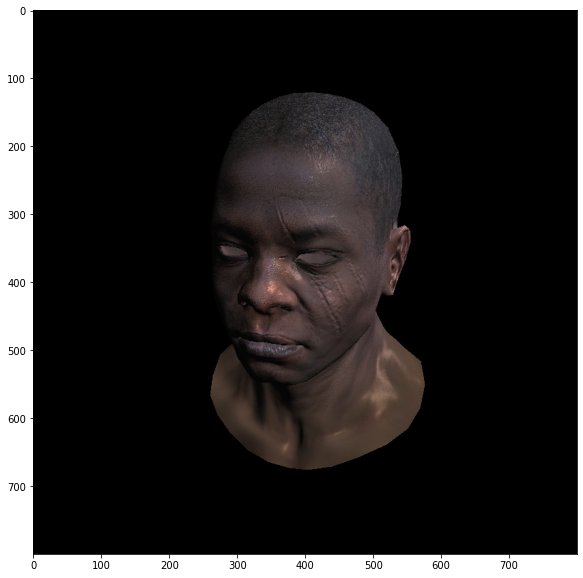

In [17]:
model = Model('./obj/african_head.obj', './obj/african_head_diffuse.png', 
              './obj/african_head_nm.png', 'obj/african_head_spec.png')
plane, z_buffer = run_render(GouraudShader_specular, model)
plt.figure(figsize=(10,10))
plt.imshow(plane.astype('int32'))

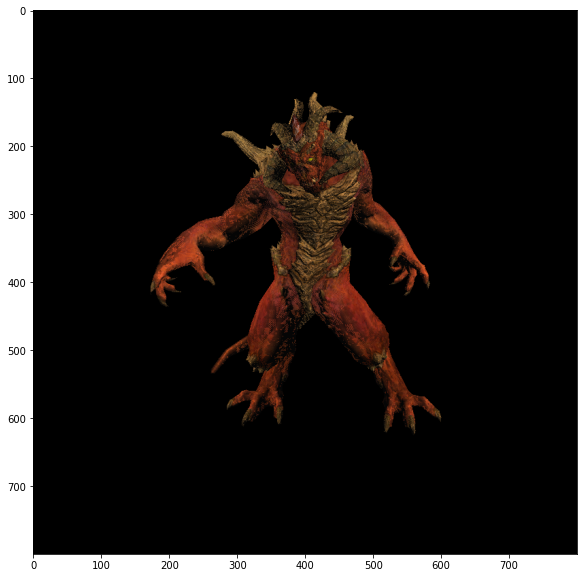

In [7]:
model = Model('./obj/diablo3_pose.obj', './obj/diablo3_pose_diffuse.png', 
              './obj/diablo3_pose_nm.png', 'obj/diablo3_pose_spec.png')
plane, z_buffer = run_render(GouraudShader_specular, model)
